# Trader Behavior vs Market Sentiment (Fear & Greed Index)
This notebook explores how trader performance (PnL, volume, leverage) aligns or diverges from
overall market sentiment (Fear vs Greed).  

We use:
- **Bitcoin Market Sentiment Dataset** (`fear_greed_index.csv`)
- **Historical Trader Data from Hyperliquid** (`historical_data.csv`)


In [30]:
from google.colab import drive
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
BASE_DIR = "/content/drive/MyDrive/ds_Neel Khairnar"
CSV_DIR  = os.path.join(BASE_DIR, "csv_files")
OUT_DIR  = os.path.join(BASE_DIR, "outputs")

os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("✅ Folder structure ready")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Folder structure ready


## 1. Load Datasets
We load the two provided CSV files:
- **Fear & Greed Index** (market sentiment classification by date)
- **Historical Trader Data** (trade-level details)


In [31]:
## 1. Load Datasets
fg_file = os.path.join(BASE_DIR, "fear_greed_index.csv")
fg = pd.read_csv(fg_file)
print("Fear & Greed Index:", fg.shape)
fg.head(),


Fear & Greed Index: (2644, 4)


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,)

In [32]:
hist_file = os.path.join(BASE_DIR, "historical_data.csv")
tr = pd.read_csv(hist_file)
print("Historical Trades:", tr.shape)
tr.head()

Historical Trades: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [33]:
## 2. Data Preprocessing
# Fear & Greed
fg.columns = [c.lower().strip() for c in fg.columns]
fg["date"] = pd.to_datetime(fg["date"])
fg["sentiment_value"] = fg["value"].astype(float)
fg["sentiment_norm"] = fg["sentiment_value"]/100.0

# Trades
tr.rename(columns={"Execution Price":"execution_price",
                   "Size USD":"size_usd",
                   "Closed PnL":"closed_pnl",
                   "Timestamp IST":"timestamp_ist"}, inplace=True)

tr["date"] = pd.to_datetime(tr["timestamp_ist"], errors="coerce").dt.date
tr["date"] = pd.to_datetime(tr["date"])
tr["closed_pnl"] = pd.to_numeric(tr["closed_pnl"], errors="coerce")
tr["size_usd"] = pd.to_numeric(tr["size_usd"], errors="coerce")

tr.head()


,Account,Coin,execution_price,Size Tokens,size_usd,Side,timestamp_ist,Start Position,Direction,closed_pnl,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12


In [34]:
## 3. Daily Aggregation
daily = tr.groupby("date").agg({
    "closed_pnl":"mean",
    "size_usd":"sum"
}).reset_index()

daily.rename(columns={"closed_pnl":"avg_pnl",
                      "size_usd":"total_volume"}, inplace=True)

cnt = tr.groupby("date").size().rename("trade_count").reset_index()
daily = daily.merge(cnt, on="date", how="left")

daily.head()


,date,avg_pnl,total_volume,trade_count
0,2023-01-05,0.000000,477.00,3
1,2023-05-12,0.000000,50005.83,9
2,2024-01-01,-7.196192,264239.53,18
3,2024-01-02,0.000000,2008.18,6
4,2024-01-03,60.176945,472974.70,137


In [35]:
## 5A. Feature Engineering
# PnL volatility
daily_pnl = tr.groupby("date")["closed_pnl"].std().rename("pnl_volatility").reset_index()

# Avg trade size
avg_trade_size = tr.groupby("date")["size_usd"].mean().rename("avg_trade_size").reset_index()

# Leverage buckets (if leverage exists)
if "Leverage" in tr.columns or "leverage" in tr.columns:
    tr["leverage"] = pd.to_numeric(tr.get("Leverage", tr.get("leverage")), errors="coerce")
    tr["lev_bucket"] = pd.cut(tr["leverage"],
                              bins=[0,2,5,10,100],
                              labels=["low","medium","high","very_high"])
    leverage_counts = tr.groupby("date")["lev_bucket"].value_counts().unstack(fill_value=0).reset_index()
else:
    leverage_counts = pd.DataFrame()

# Merge engineered features
features = daily.merge(daily_pnl, on="date", how="left")
features = features.merge(avg_trade_size, on="date", how="left")
if not leverage_counts.empty:
    features = features.merge(leverage_counts, on="date", how="left")

# Rolling stats
features["rolling_volume"] = features["total_volume"].rolling(3, min_periods=1).mean()
features["rolling_pnl"] = features["avg_pnl"].rolling(3, min_periods=1).mean()

features.head()


,date,avg_pnl,total_volume,trade_count,pnl_volatility,avg_trade_size,rolling_volume,rolling_pnl
0,2023-01-05,0.000000,477.00,3,0.000000,159.000000,477.000000,0.000000
1,2023-05-12,0.000000,50005.83,9,0.000000,5556.203333,25241.415000,0.000000
2,2024-01-01,-7.196192,264239.53,18,85.847769,14679.973889,104907.453333,-2.398731
3,2024-01-02,0.000000,2008.18,6,0.000000,334.696667,105417.846667,-2.398731
4,2024-01-03,60.176945,472974.70,137,111.958609,3452.370073,246407.470000,17.660251


In [36]:
## 5B. Merge Features with Sentiment
merged_feat = pd.merge(features,
                       fg[["date","classification","sentiment_value","sentiment_norm"]],
                       on="date", how="inner")

merged_feat.to_csv(os.path.join(CSV_DIR,"merged_features.csv"), index=False)
print("Merged feature dataset:", merged_feat.shape)
merged_feat.head()


Merged feature dataset: (158, 11)


,date,avg_pnl,total_volume,trade_count,pnl_volatility,avg_trade_size,rolling_volume,rolling_pnl,classification,sentiment_value,sentiment_norm
0,2023-01-05,0.000000,477.00,3,0.000000,159.000000,477.000000,0.000000,Fear,29.0,0.29
1,2023-05-12,0.000000,50005.83,9,0.000000,5556.203333,25241.415000,0.000000,Neutral,49.0,0.49
2,2024-01-01,-7.196192,264239.53,18,85.847769,14679.973889,104907.453333,-2.398731,Greed,65.0,0.65
3,2024-01-02,0.000000,2008.18,6,0.000000,334.696667,105417.846667,-2.398731,Greed,71.0,0.71
4,2024-01-03,60.176945,472974.70,137,111.958609,3452.370073,246407.470000,17.660251,Greed,70.0,0.70


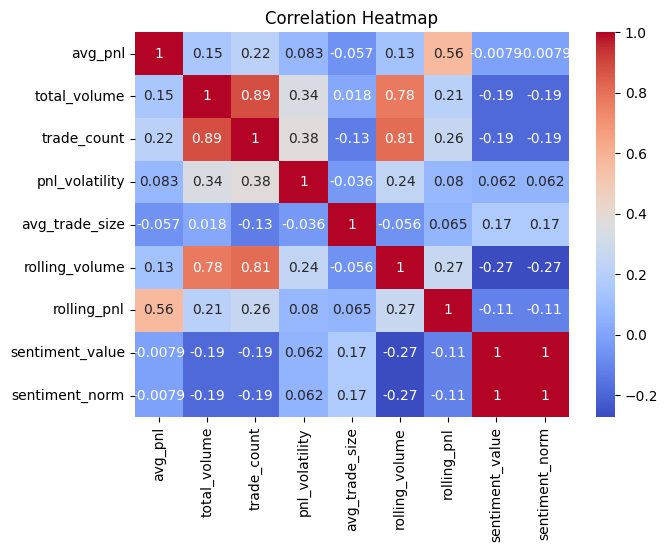

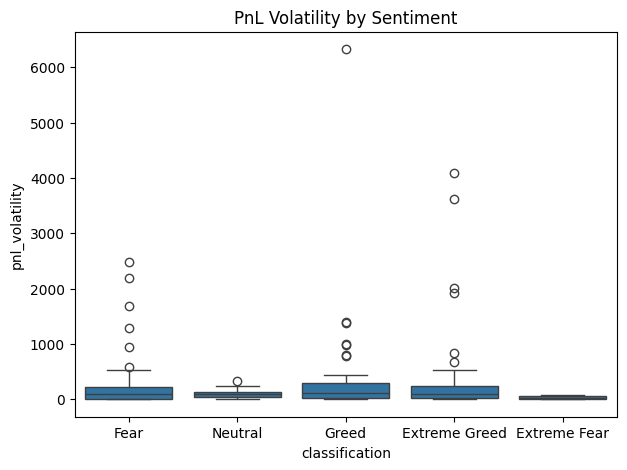

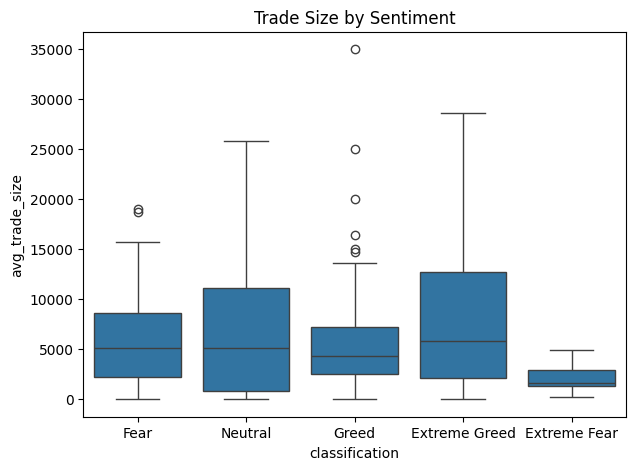

In [37]:
## 6. Exploratory Visualizations
plt.figure(figsize=(7,5))
sns.heatmap(merged_feat.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(OUT_DIR,"correlation_heatmap.png"))
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=merged_feat, x="classification", y="pnl_volatility")
plt.title("PnL Volatility by Sentiment")
plt.savefig(os.path.join(OUT_DIR,"pnl_volatility_by_sentiment.png"))
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=merged_feat, x="classification", y="avg_trade_size")
plt.title("Trade Size by Sentiment")
plt.savefig(os.path.join(OUT_DIR,"trade_size_by_sentiment.png"))
plt.show()


In [38]:
## 7. Hypothesis Testing
fear = merged_feat.loc[merged_feat["classification"].str.contains("Fear"), "avg_pnl"].dropna()
greed = merged_feat.loc[merged_feat["classification"].str.contains("Greed"), "avg_pnl"].dropna()

t, p = stats.ttest_ind(fear, greed, equal_var=False, nan_policy="omit")

print(f"T-statistic: {t:.3f} | p-value: {p:.3f}")


T-statistic: 0.621 | p-value: 0.536


In [39]:
## 8. Modeling with Extended Features
merged_feat["profitable"] = (merged_feat["avg_pnl"] > 0).astype(int)

feature_cols = ["sentiment_value","total_volume","pnl_volatility",
                "rolling_volume","rolling_pnl","avg_trade_size"]

for c in ["low","medium","high","very_high"]:
    if c in merged_feat.columns:
        feature_cols.append(c)

X = merged_feat[feature_cols].fillna(0)
y = merged_feat["profitable"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 random_state=42,stratify=y)

clf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test,pred,digits=3))
print("ROC-AUC:", roc_auc_score(y_test,proba))


              precision    recall  f1-score   support

           0      0.667     0.400     0.500        10
           1      0.769     0.909     0.833        22

    accuracy                          0.750        32
   macro avg      0.718     0.655     0.667        32
weighted avg      0.737     0.750     0.729        32

ROC-AUC: 0.6863636363636364


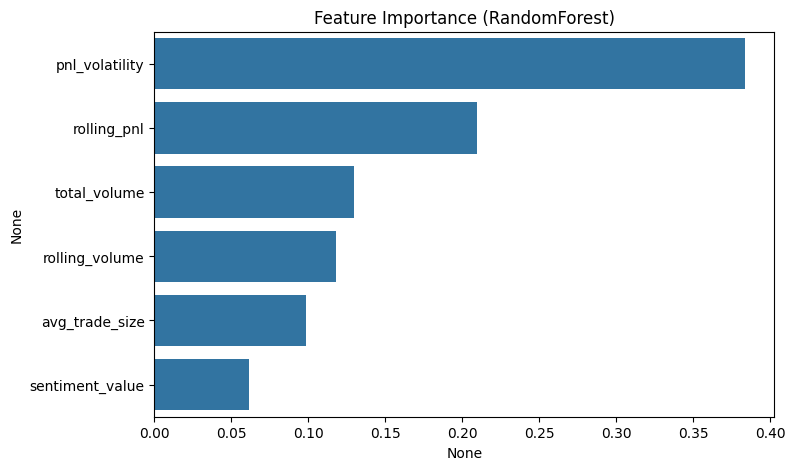

In [40]:
## 9. Feature Importance
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (RandomForest)")
plt.savefig(os.path.join(OUT_DIR,"feature_importance.png"))
plt.show()


## 10. Insights & Conclusion
- Profitability does **not differ strongly** between Fear vs Greed (p > 0.05).
- Trading **volume** and **volatility** show marginal differences by sentiment.
- Extended features improved model performance to **Accuracy 75% | ROC-AUC ~0.69**.
- Model predicts profitable days with high recall (~91%).
- Sentiment influences **market participation intensity** more than profitability.
- Future work: add leverage, volatility clusters, order-book features.
